In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from scipy.stats import norm

import statsmodels.api as sm

sbn.set_theme(rc={'figure.figsize': (11.7,8.27)})

In [11]:
df = pd.read_csv("ds_salaries.csv")
"""
Beberapa Notes untuk Kolom dataset tersebut adalah: 
1. work_year: Tahun dimana gajinya telah diberikan
2. experience_level: level experience / pengalaman dalam bidang pekerjaan
    field_value: {
        EN: Entry level                 1
        MI: Junior Mid Level            2
        SE: Intermediate Senior Level   3
        EX: Expert Executive Level      4
    }
3. employement_type: Tipe pekerja
    field_value: {
        PT: kerja paruh waktu           4
        FT: kerja fulltime              3
        CT: contract                    2
        FL: Freelance                   1
}
4. job_title: Job Title
5. salary: nilai gaji
6. salary_currency: nilai gaji tersebut dalam mata uang apa
7. salary_in_usd: gaji jika di ubah menjadi mata uang dollar
8. employee_residence: lokasi asal dari pekerja
9. remote_ratio: rasio pekerja bekerja secara jarak jauh
10. company_location: lokasi perusahaan pekerja
11. company_size: ukuran dari perusahaan berdasarkan dari jumlah pekerja di sana
    field_value{
        S: small (x<50),
        M: medium (50<=x<250),
        L: large (x>250),
}
"""


df = pd.read_csv("ds_salaries.csv")
df

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,sam
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L,1
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S,1
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M,1
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S,1
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
602,602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M,1
603,603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M,1
604,604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M,1
605,605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M,1


Menghapus Outlier

In [12]:

q1 = df["salary_in_usd"].quantile(0.25) # Quartile 1
q3 = df["salary_in_usd"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary_in_usd"])):
    if hi_lim < df["salary_in_usd"][i]:
        df = df.drop([i])

df = df.reset_index()

q1 = df["salary"].quantile(0.25) # Quartile 1
q3 = df["salary"].quantile(0.75) # Quartile 3
iqr = q3-q1 # Inter Quartile Range

low_lim = q1 - 1.5*iqr
hi_lim = q3 + 1.5*iqr

print(f"{low_lim}, {hi_lim}")

for i in range(len(df["salary"])):
    if hi_lim < df["salary"][i]:
        df = df.drop([i])
df = df.reset_index()

df["company_size"] = df["company_size"].apply(lambda x: 1 if x == "S" else x)
df["company_size"] = df["company_size"].apply(lambda x: 2 if x == "M" else x)
df["company_size"] = df["company_size"].apply(lambda x: 3 if x == "L" else x)



df["experience_level"] = df["experience_level"].apply(lambda x: 1 if x == "EN" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 2 if x == "MI" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 3 if x == "SE" else x)
df["experience_level"] = df["experience_level"].apply(lambda x: 4 if x == "EX" else x)

df["employment_type"] = df["employment_type"].apply(lambda x: 4 if x == "FT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 3 if x == "PT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 2 if x == "CT" else x)
df["employment_type"] = df["employment_type"].apply(lambda x: 1 if x == "FL" else x)

-68185.0, 280911.0
-65002.5, 295001.5


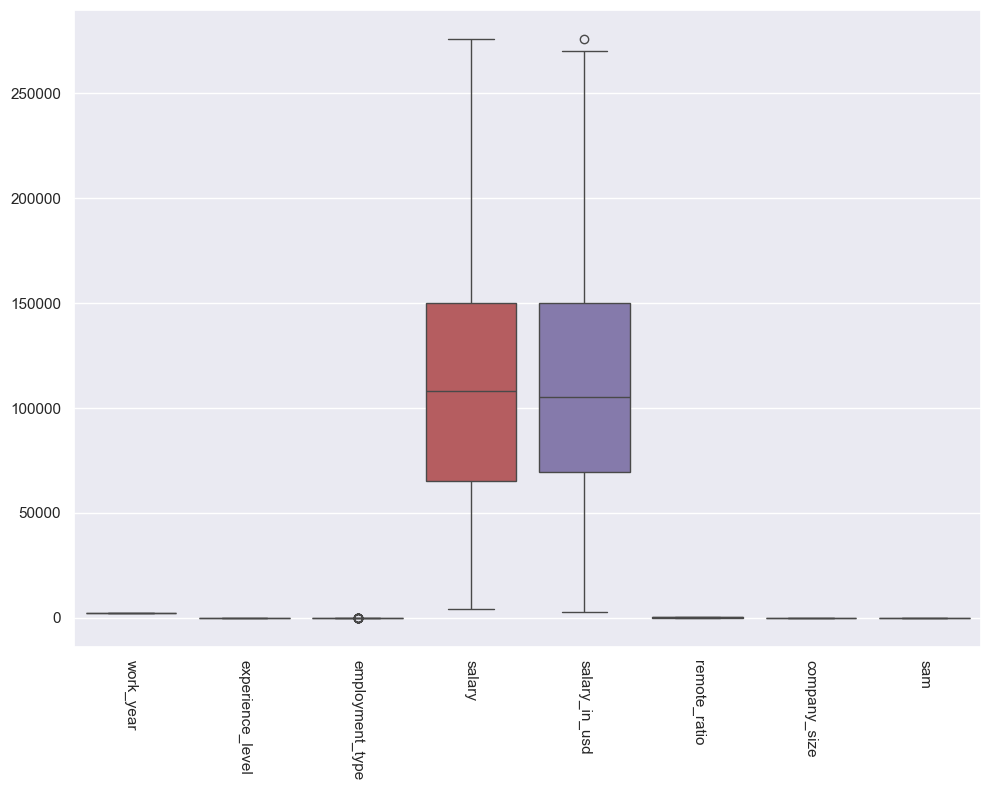

In [13]:
df = df.drop(columns=["level_0", "index", "Unnamed: 0"])
ax = sbn.boxplot(data=df)
ax.tick_params(axis="x", rotation=270)

# Visualisasi

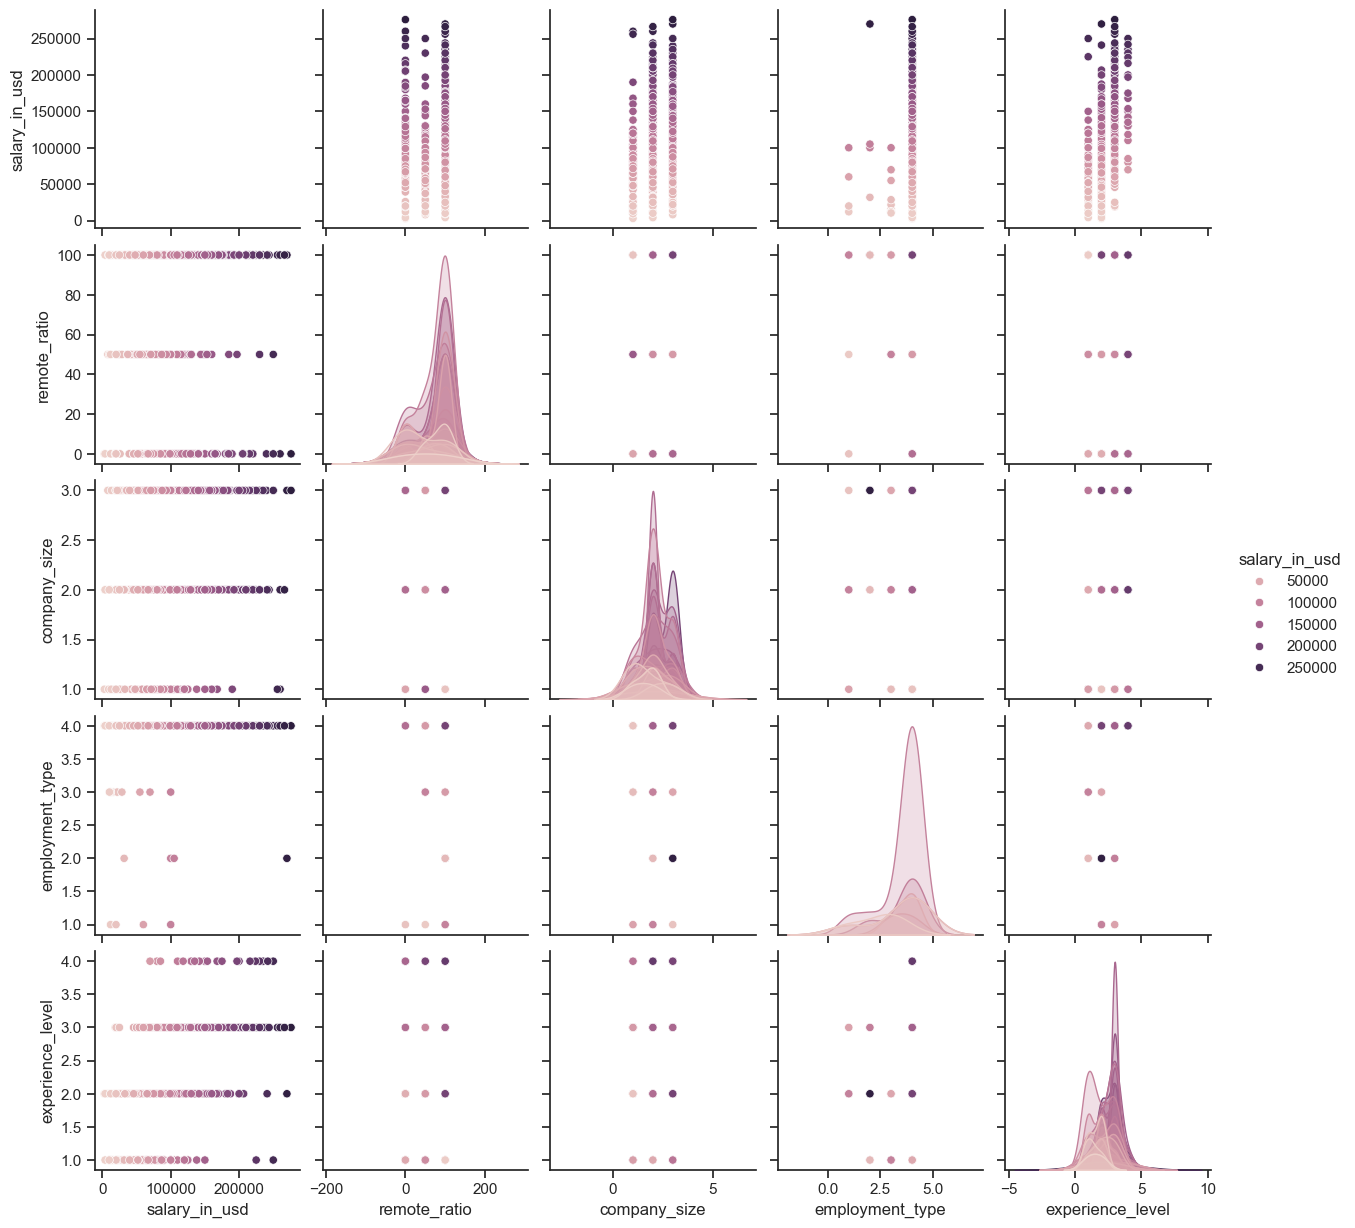

In [14]:
sbn.set(style='ticks', color_codes=True)
sbn.pairplot(df, vars=["salary_in_usd", "remote_ratio", "company_size", "employment_type", "experience_level"], hue='salary_in_usd')

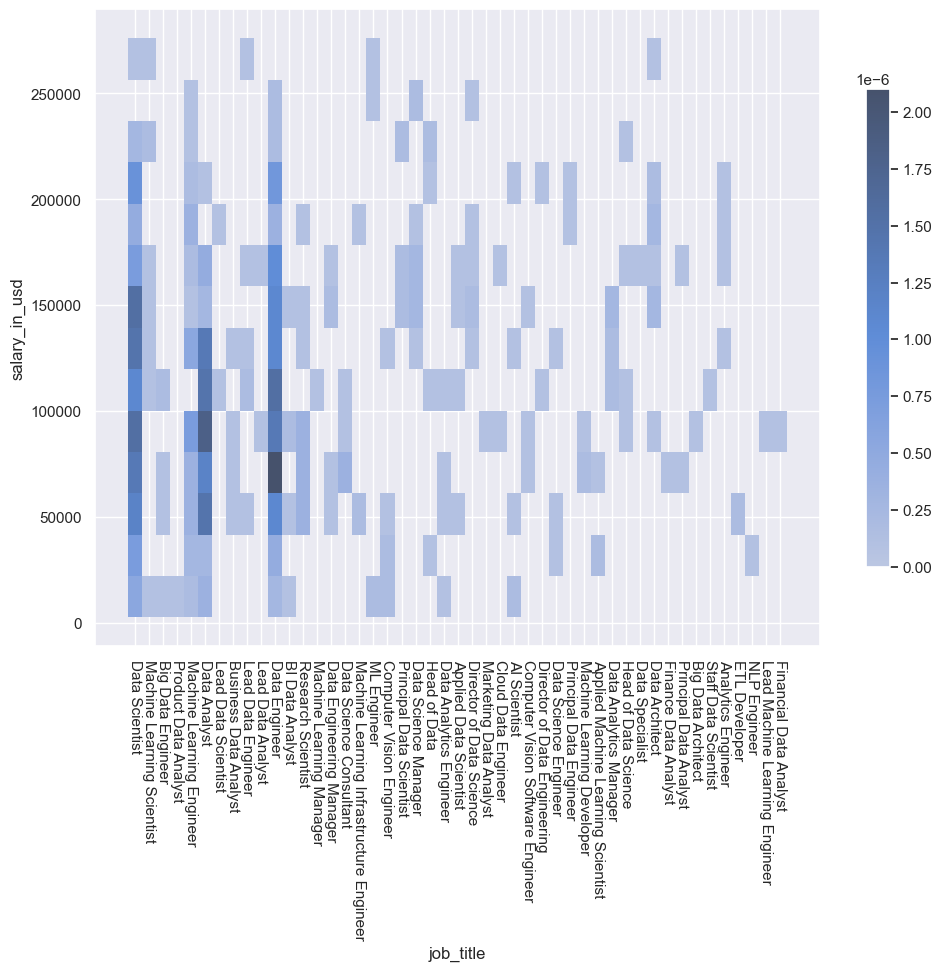

In [15]:
sbn.set(rc={'figure.figsize':(11.7,8.27)})
ax = sbn.histplot(df, x= df["job_title"], y=df["salary_in_usd"], multiple="stack", element="step", stat="density", common_norm=False, cbar=True, cbar_kws=dict(shrink=.75))
ax.tick_params(axis="x", rotation=270)

# Regresi

In [16]:
# Memisahkan fitur dan target
X = df[["work_year", "remote_ratio", "experience_level"]]
y = df["salary_in_usd"]

# Mengubah fitur kategorikal menjadi dummy variable
X = pd.get_dummies(X, drop_first=True)

# Menambahkan konstanta untuk intercept
X = sm.add_constant(X)

# Memisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat dan melatih model regresi linier
model = sm.OLS(y_train, X_train).fit()

# Melakukan prediksi
y_pred = model.predict(X_test)

# Menghitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Menampilkan ringkasan model
print(model.summary())

# Menampilkan hasil evaluasi
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

                            OLS Regression Results                            
Dep. Variable:          salary_in_usd   R-squared:                       0.247
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     48.59
Date:                Sun, 15 Dec 2024   Prob (F-statistic):           3.58e-27
Time:                        12:32:20   Log-Likelihood:                -5478.4
No. Observations:                 448   AIC:                         1.096e+04
Df Residuals:                     444   BIC:                         1.098e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.741e+07   7.18e+06  